In [1]:
# google drive mount

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# dependencies - import your own

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
from PIL import Image
from keras.utils import normalize

In [9]:

# desired size i would like to consider
desired_size = (128, 128)

# elloborating code structure to load imgs for better understanding

# path to the folder containing

# images - google drive
imgs_path = "/content/drive/MyDrive/UNet Project/Unet_dataset/images_brain_tum/"

# masks - google drive
masks_path = "/content/drive/MyDrive/UNet Project/Unet_dataset/masks_brain_tum"

# Initialize empty lists to store the resized images and masks - basically creating empty list
resized_images = []
resized_masks = []

# now load

#  images
image_files = glob.glob(imgs_path + "/*.jpg")  # Update the extension if necessary

# masks
mask_files = glob.glob(masks_path + "/*.jpg")  # Update the extension if necessary


for img_file, mask_file in zip(image_files, mask_files):
    # Load the image and mask using OpenCV
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    # resize
    img_resized = cv2.resize(img, desired_size, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, desired_size, interpolation=cv2.INTER_LINEAR)

    # normalize
    img_resized = np.expand_dims(img_resized, axis=-1) / 255.0
    mask_resized = np.expand_dims(mask_resized, axis=-1) / 255.0

    # Append the resized images and masks to the respective lists
    resized_images.append(img_resized)
    resized_masks.append(mask_resized)

# Convert the resized images and masks to numpy arrays
train_images = np.array(resized_images)
mask_images = np.array(resized_masks)

# Print the shape of the resized images and masks
print("Resized Images Shape:", train_images.shape)
print("Resized Masks Shape:", mask_images.shape)


Resized Images Shape: (705, 128, 128, 1)
Resized Masks Shape: (705, 128, 128, 1)


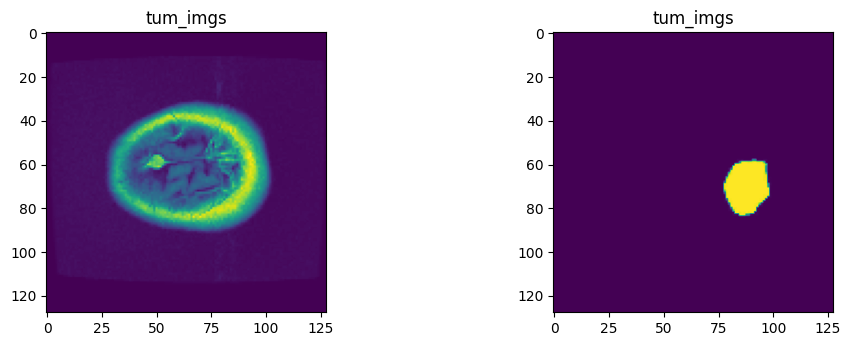

In [10]:
# try

import random

img_no = random.randint(0, len(train_images))

img = train_images[img_no]

mask = mask_images[img_no]

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.title('tum_imgs')
plt.imshow(img)

plt.subplot(222)
plt.title('tum_imgs')
plt.imshow(mask)

plt.show()


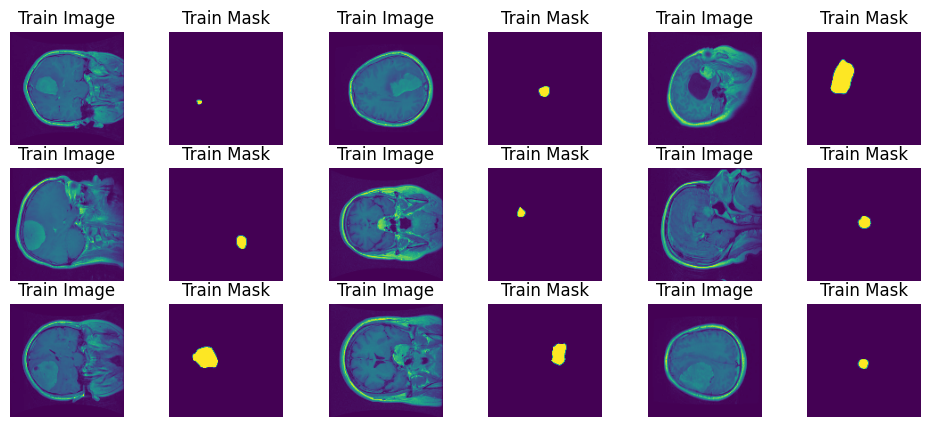

In [11]:
# try

plt.figure(figsize=(12, 5))

i=1
for idx in np.random.randint(train_images.shape[0], size=9):

  plt.subplot(3,6,i);i+=1
  plt.imshow(train_images[idx])
  plt.title("Train Image")
  plt.axis('off')

  plt.subplot(3,6,i);i+=1
  plt.imshow(mask_images[idx])
  plt.title("Train Mask")
  plt.axis('off')

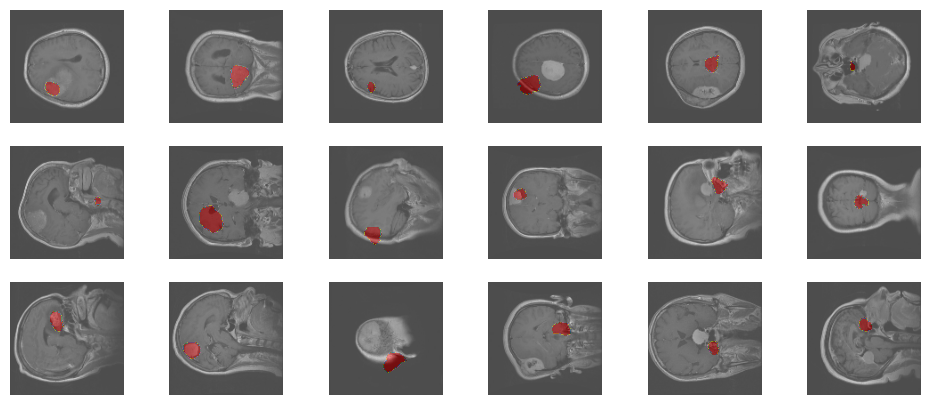

In [12]:
# try it in gray_scale

plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(train_images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(train_images[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(mask_images[idx])-mask_images[idx],axis=-1), alpha=0.5, cmap='Set1')
    # plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

In [13]:
from sklearn.model_selection import train_test_split
import gc

# general method

X,X_v,Y,Y_v = train_test_split( train_images,mask_images,test_size=0.2)
del train_images
del mask_images
gc.collect()
X.shape,X_v.shape

((564, 128, 128, 1), (141, 128, 128, 1))

In [14]:
X.dtype,X_v.dtype # check

(dtype('float64'), dtype('float64'))

In [15]:
# trying with appending

X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
X.shape,Y.shape

((1128, 128, 128, 1), (1128, 128, 128, 1))

In [16]:
X.dtype,Y.dtype # checking everytime to connfirm

(dtype('float64'), dtype('float64'))

In [17]:
# trying Augumentation

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()

In [18]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

# Defining Dice Loss

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# bce_dice_loss = binary_crossentropy_loss + dice_loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [24]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model

IMG_DIM = (128, 128, 1) # resized image size from given image size i.e (512,512, 3)
# IMG_DIM_uint8 = np.array(IMG_DIM).astype(np.uint8)


def conv2d_block(input_tensor, n_filters, kernel_size=(3, 3), name="contraction"):
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
               padding='same', activation="relu", name=name + '_1')(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
               padding='same', activation="relu", name=name + '_2')(x)
    return x

inp = Input(shape=IMG_DIM)


d1 = conv2d_block(inp, 32, name="contraction_1")
p1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block(p1, 64, name="contraction_2_1")
p2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block(p2, 128, name="contraction_3_1")
p3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3, 256, name="contraction_4_1")
p4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4, 256, name="contraction_5_1")

u1 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(d5)
u1 = concatenate([u1, d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 256, name="expansion_1")

u2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c1)
u2 = concatenate([u2, d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 128, name="expansion_2")

u3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c2)
u3 = concatenate([u3, d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 64, name="expansion_3")

u4 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c3)
u4 = concatenate([u4, d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4, 32, name="expansion_4")

out = Conv2D(1, (1, 1), name="output", activation='sigmoid')(c4)

unet = Model(inp, out)
unet.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 contraction_1_1 (Conv2D)       (None, 128, 128, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 contraction_1_2 (Conv2D)       (None, 128, 128, 32  9248        ['contraction_1_1[0][0]']        
                                )                                                           

In [32]:
# getting intersection_over_union vector calculation

def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

#  metric calculation for intersection_over_union

def iou_metric(label, pred):
    return tf.numpy_function(get_iou_vector, [label, pred>0.5], tf.float64)

unet.compile(optimizer=optimizers.Adam(lr=1e-3),
             loss=bce_dice_loss, metrics=['accuracy',iou_metric])

# getting intersection_over_union curve

def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

# normal dependencies
# trying to save the best model

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

# from image_loader get the datagen

train_generator = train_datagen.flow(X, Y, batch_size=32)
val_generator = val_datagen.flow(X_v, Y_v, batch_size=32)


# model training step

hist = unet.fit(X,Y,batch_size=32,epochs=10,
               validation_data=(X_v,Y_v),verbose=1,callbacks= callback_list)

unet = load_model('model_best_checkpoint.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':iou_metric}) #or compile = False

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 1.0268 - accuracy: 0.9751 - iou_metric: 0.0015
Epoch 1: val_loss improved from inf to 1.00317, saving model to model_best_checkpoint.h5
36/36 [==============================] - 27s 355ms/step - loss: 1.0268 - accuracy: 0.9751 - iou_metric: 0.0015 - val_loss: 1.0032 - val_accuracy: 0.9783 - val_iou_metric: 9.3009e-04 - lr: 0.0010
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.9701 - accuracy: 0.9768 - iou_metric: 0.0113
Epoch 2: val_loss improved from 1.00317 to 0.98440, saving model to model_best_checkpoint.h5
36/36 [==============================] - 7s 201ms/step - loss: 0.9701 - accuracy: 0.9768 - iou_metric: 0.0113 - val_loss: 0.9844 - val_accuracy: 0.9735 - val_iou_metric: 0.0382 - lr: 0.0010
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.9668 - iou_metric: 0.0814
Epoch 3: val_loss did not improve from 0.98440
36/36 [==============================] - 

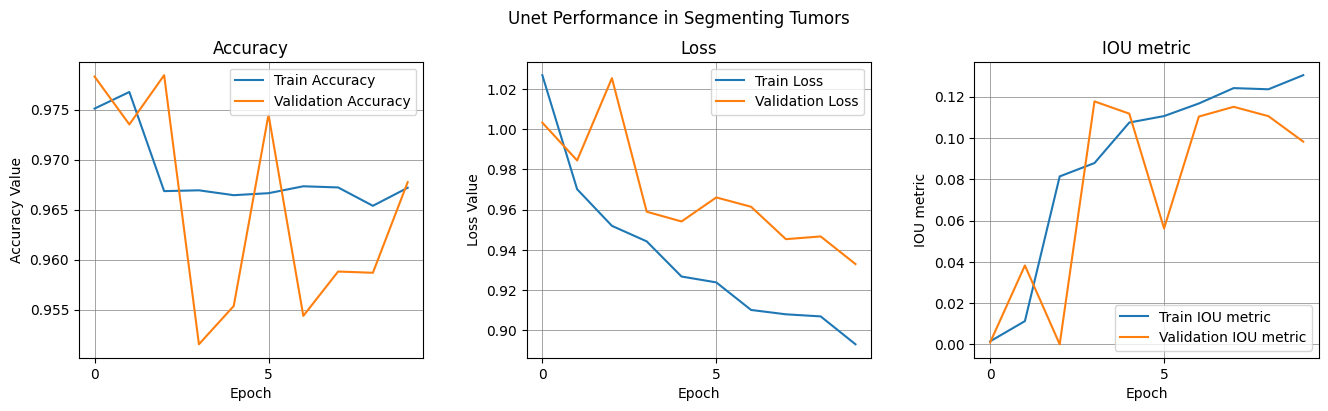

In [31]:
# trying to define accuracy , loss and intersection_over_union for 10 epochs - Study Group - pls try with higher epochs for better accuracy


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Performance U-Net Segmenting Brain Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

# accuracy

ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

# loss

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

# intersection_over_union

ax3.plot(epoch_list, hist.history['iou_metric'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_iou_metric'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)


36/36 [==============================] - 2s 42ms/step


Text(0.5, 1.0, 'Threshold vs IoU (0.11111111111111112, 0.1519505902196464)')

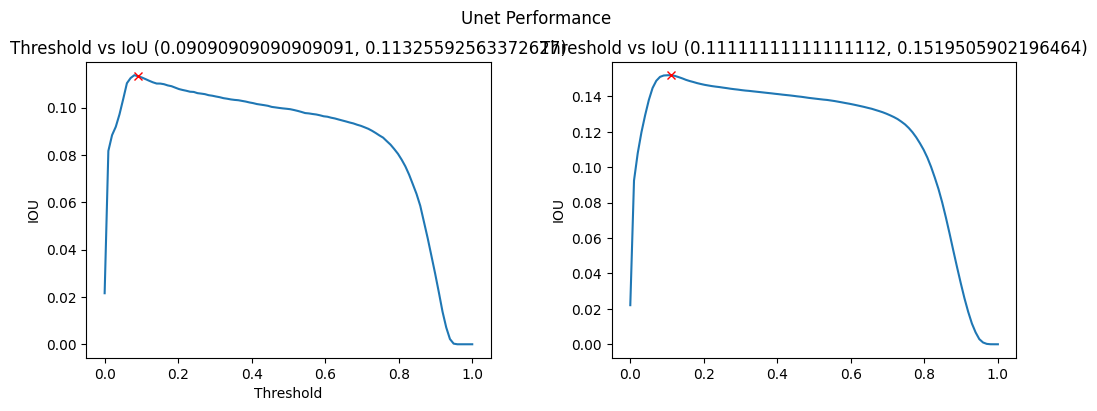

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_v,unet.predict(X_v))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

5/5 [==============================] - 0s 58ms/step


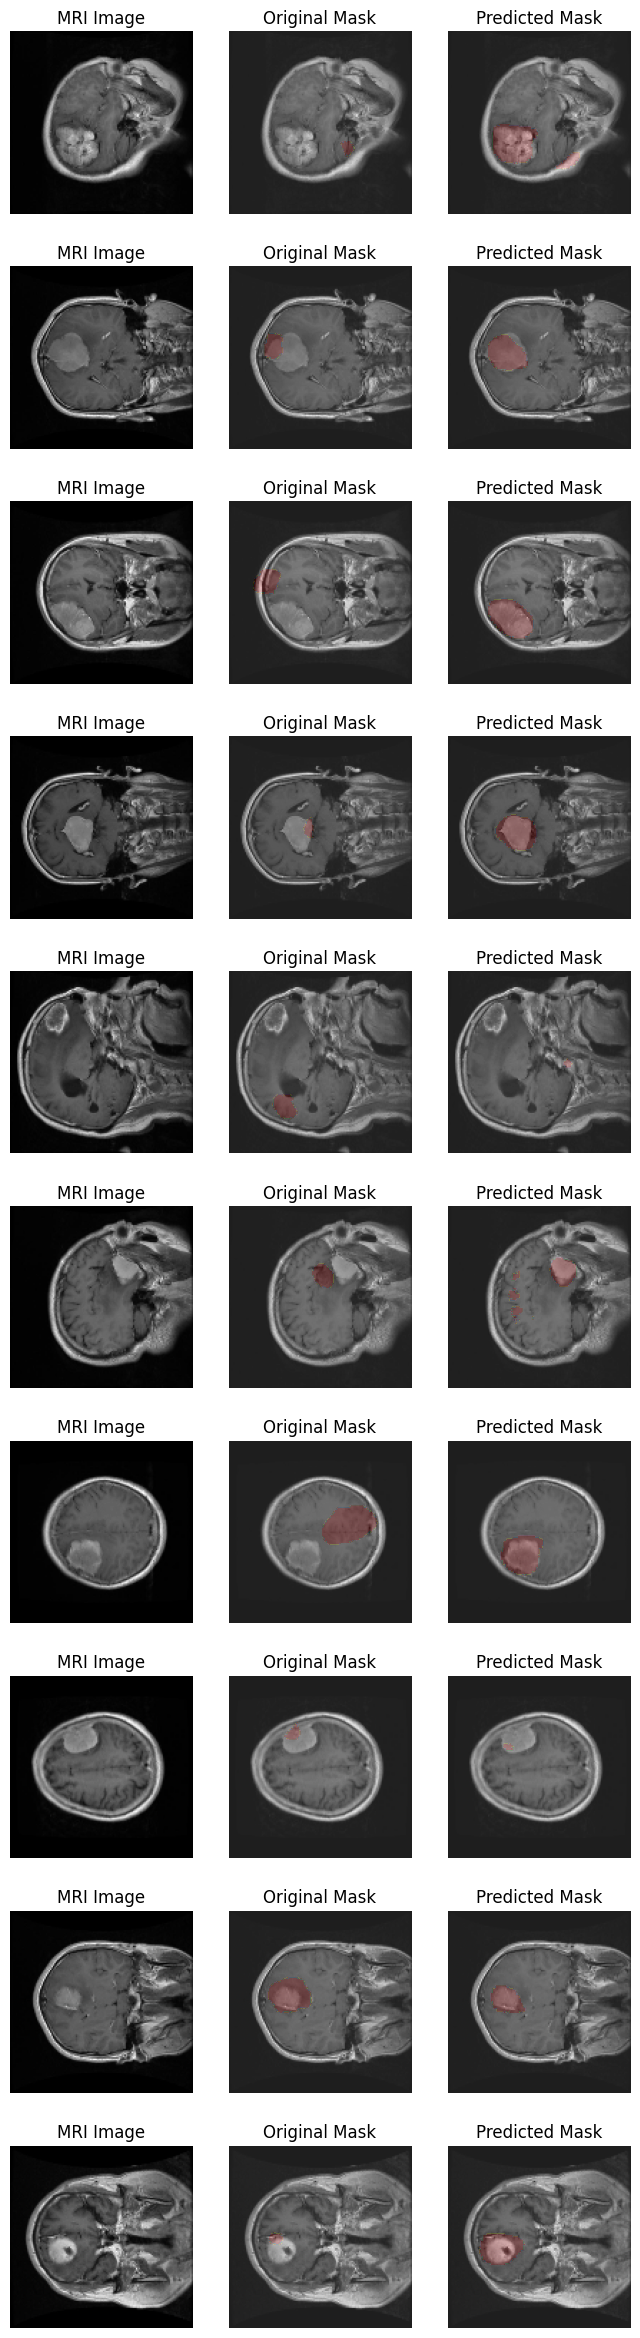

In [34]:
THRESHOLD = 0.5
predicted_mask = (unet.predict(X_v)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like( Y_v[0] )
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[idx],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[idx],axis=-1),  alpha=0.2, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')